# Hier werden die Ergebnisse mit SHAP analysiert

In [6]:
# General tools
import os
from pathlib import Path
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# To save the modells
from joblib import dump, load

# For transformations and predictions
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from xgboost import XGBRegressor

# For Optimization
from sklearn.model_selection import GridSearchCV
# For scoring
from sklearn.metrics import mean_squared_error as mse
from sklearn import metrics

# For validation
from sklearn.model_selection import train_test_split as train_test_split

# Wichtig um den Graphen zu Plotten
from sklearn import tree

# package used to calculate Shap values
import shap

In [2]:
def Model_import(str_Verfahren, Datensatz,Optimierung):
    base_dir = Path.cwd()
    filename = Path(str_Verfahren+ '_' + Datensatz+ '_' + Optimierung + '.joblib')
    path = os.path.join(base_dir, filename)
    return load(path)

In [3]:
def Data_preprossesing(df, Optimierung):
    """
    Diese Funktion erhält einen DF und soll diesen in den Test_Train_split durchführen 
    und ggf. Frac bei großen Aufgaben
    """
    np.random.seed(10)
    remove_n = 0
    drop_indices = np.random.choice(df.index, remove_n, replace=False)
    # Hier wurden die Jahre in Dekaden umgewandelt. Das Ergebniss war allerdings schlechter, als die normalen Jahre
    #df['Dekade']= df['year']%100
    #df = df.drop('year', axis=1)
    df = df.drop(drop_indices)
    if Optimierung == "Keine":
        X = df.drop(['popularity','artists', 'id','name','release_date'], axis=1)
    elif Optimierung == "Jahr_gedroppt":
        X = df.drop(['popularity','artists', 'id','name','release_date','year'], axis=1)
    else:
        print('Kein Optimierung ausgewählt. Optimierung:', Optimierung)
    y = df['popularity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X, X_train, X_test, y_train, y_test

In [4]:
def X_Train_import(Datensatz):
    base_dir = Path.cwd()
    if Datensatz == 'Raw':
        filename = Path('data.csv')
    elif Datensatz == 'Cleaned':
        #path = 'data_cleaned.csv'
        filename = Path('data_cleaned.csv')
    else: 
        print('Kein Datensatz ausgewählt. Datensatz:',Datsatz)
    path = os.path.join(base_dir, filename)
    return pd.read_csv(path)

In [5]:
# List_* enthält alle Möglichen Attribute
list_Datensatz = ['Raw',"Cleaned"]
list_Optimierung = ["Keine", "Jahr_gedroppt"]
list_str_Verfahren = ["Lineare_Regression", "KNN","Decision_Tree","Decision_Tree_grid","Random_Forest", "XGBoost"]
Scoring_Table = pd.DataFrame()

# Hier kann das gewünschte Model ausgewählt werden
Datensatz= "Cleaned"
Optimierung = "Jahr_gedroppt"
str_Verfahren = "Decision_Tree"

df = X_Train_import(Datensatz)
X, X_train, X_test, y_train, y_test = Data_preprossesing(df, Optimierung)
model = Model_import(str_Verfahren, Datensatz,Optimierung)

NameError: name 'pd' is not defined

In [40]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)

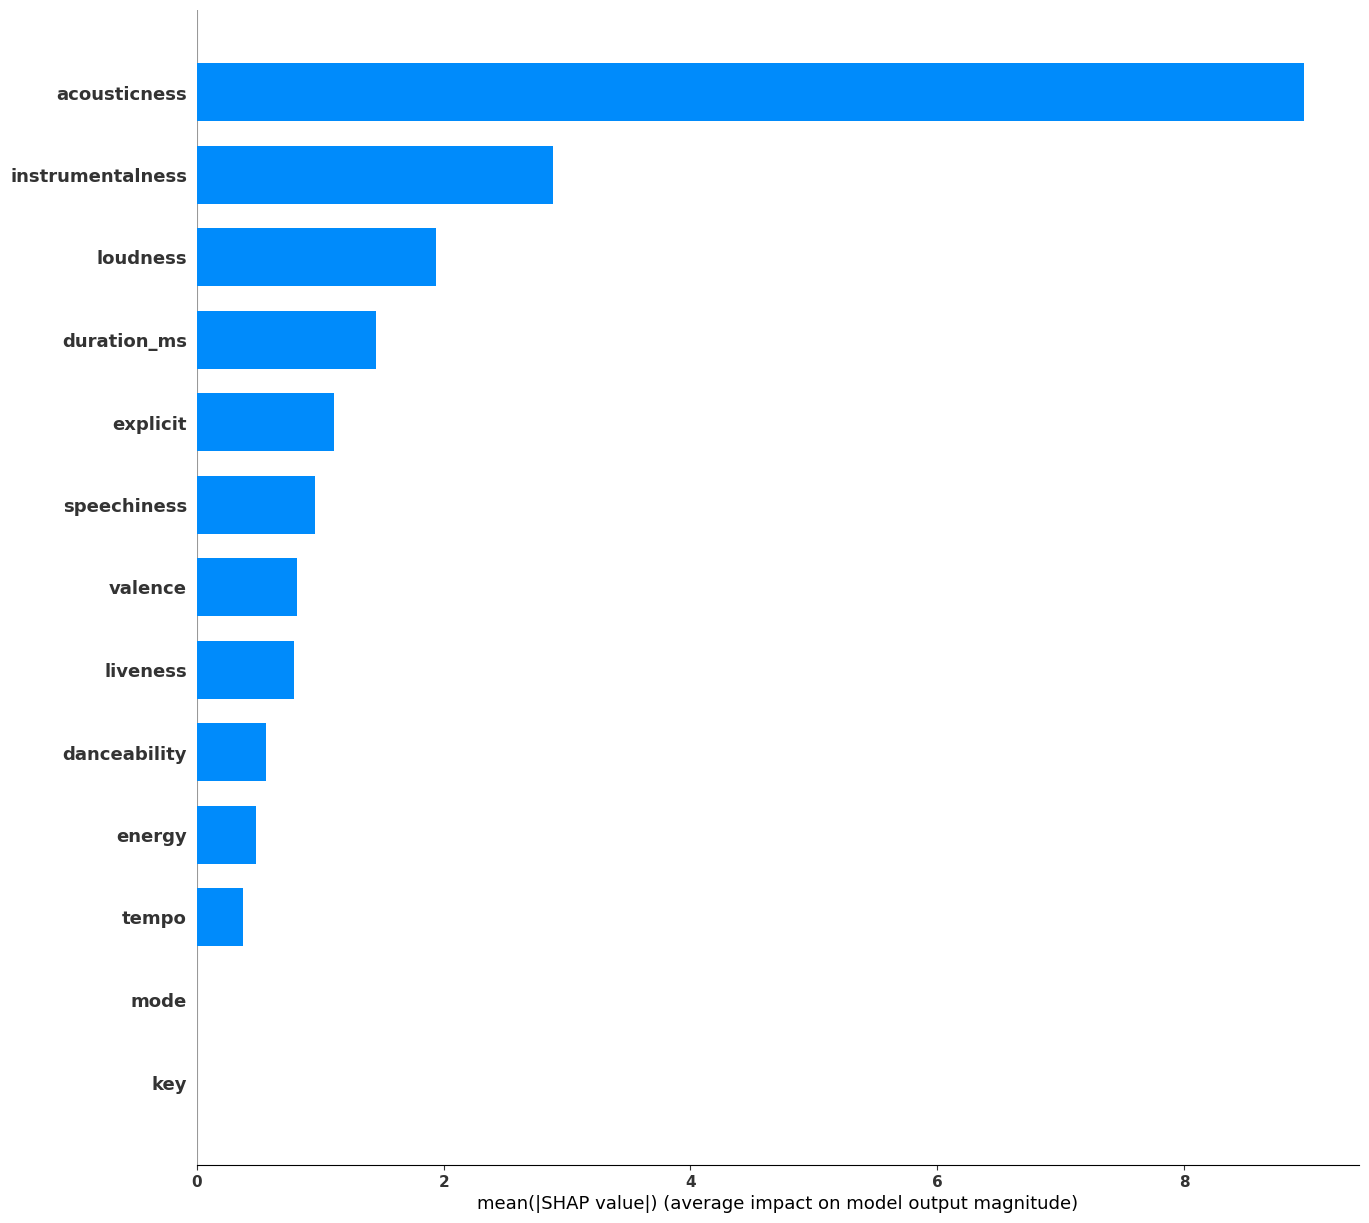

In [41]:
shap.summary_plot(shap_values, X_train, plot_type="bar", plot_size=(15,15), auto_size_plot=True)

In [42]:
plt.rcParams.update({'font.size': 40})
plt.rcParams.update({'font.weight': 1000})
shap.summary_plot(shap_values, X_train,plot_size=(17,13),show=False)
plt.savefig('SHAP_impact_on_output.pdf',bbox_inches='tight',transparent=True)

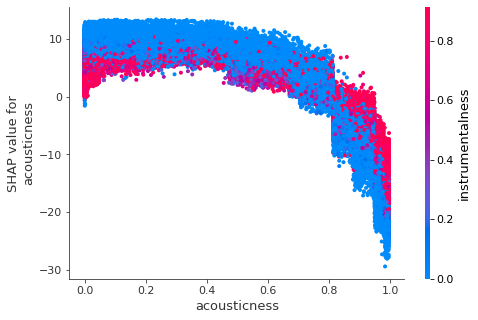

In [15]:
shap.dependence_plot("acousticness", shap_values, X_train)

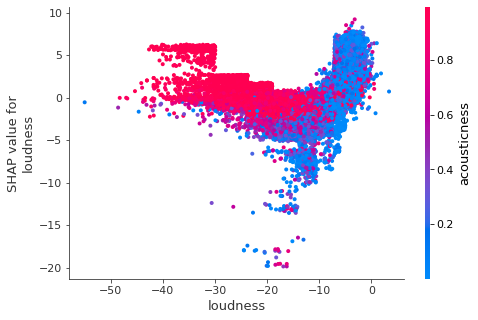

In [16]:
shap.dependence_plot("loudness", shap_values, X_train)

In [182]:
X_output = X_test.copy()
X_output.loc[:,'popularity predicted'] = np.round(model.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,330,50) # Every 50 rows
S = X_output.iloc[random_picks]
S

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,popularity predicted
147778,0.960000,0.346,163867,0.170,0,0.916000,0,0.2040,-14.784,1,0.0363,75.987,0.110,15.82
3652,0.948000,0.663,303387,0.520,0,0.048600,2,0.0556,-5.766,1,0.0494,132.572,0.827,13.63
124122,0.123000,0.765,287533,0.753,0,0.003830,1,0.0396,-12.001,1,0.0614,103.634,0.944,38.14
126304,0.554000,0.738,266173,0.753,0,0.000016,2,0.1320,-6.476,0,0.0393,91.902,0.910,40.98
50375,0.000013,0.423,287053,0.808,0,0.793000,6,0.2930,-10.652,0,0.0331,138.991,0.208,10.67
91897,0.476000,0.288,209440,0.284,0,0.000065,11,0.1130,-11.641,1,0.0298,133.925,0.246,36.14
32614,0.027400,0.820,226821,0.659,1,0.000000,1,0.1110,-6.875,1,0.2190,114.580,0.297,57.09


In [183]:
df_merged = pd.merge(S, df[["artists","name", "popularity"]], left_index=True, right_index=True)

In [185]:
df_merged.to_excel('SHAP_Prediction.xlsx', index=False)

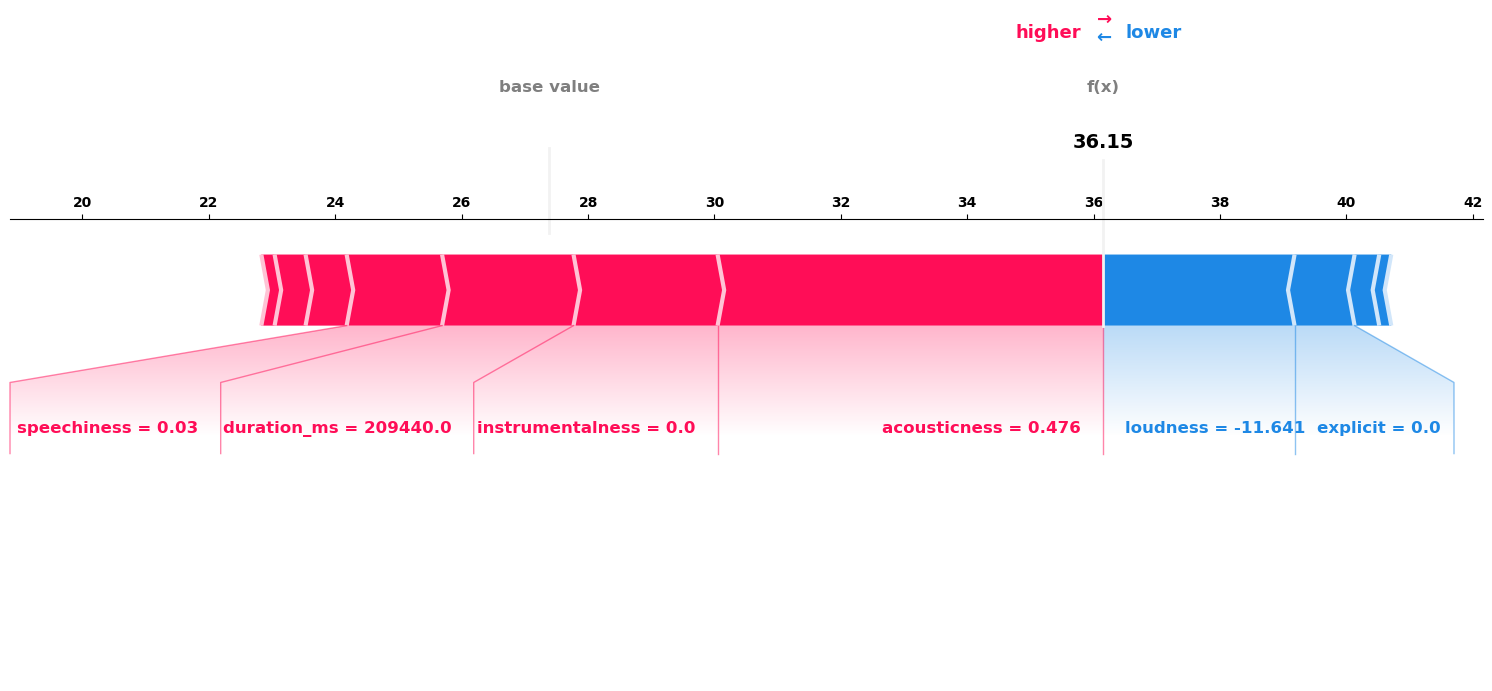

In [59]:
%matplotlib inline
from pylab import rcParams
shap.initjs()
j =5 
explainerModel = shap.TreeExplainer(model)
shap_values_Model = explainerModel.shap_values(S)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'font.weight': 1000})
plt.rcParams['axes.titlesize'] = 20
plt.rcParams.update({"figure.figsize": (20,10)})
fig = shap.force_plot(explainerModel.expected_value.round(2), shap_values_Model[j,:].round(2), S.iloc[j,:].round(3), show=True,matplotlib=True,figsize=(19, 6),contribution_threshold=0.1) 
plt.savefig('SHAP_strahl.pdf',bbox_inches='tight',transparent=True)